# DAE - Denoising Auto Encoder

In [3]:
# https://towardsdatascience.com/denoising-autoencoders-dae-how-to-use-neural-networks-to-clean-up-your-data-cd9c19bc6915
import torch
import torchvision
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu_count = os.cpu_count()

# Custom transforms to add noise to images

In [4]:
from typing import Any
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import random


class AddGaussianNoise():
    def __init__(self, mean=0.0, std=1.0):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Input image.

        Returns:
            PIL Image: Image with added noise.
        """
        img = transforms.ToTensor()(img)
        noise = torch.randn_like(img) * self.std + self.mean
        noisy_img = img + noise
        noisy_img = torch.clamp(noisy_img, 0, 1)  # Clip values to [0, 1]
        return transforms.ToPILImage()(noisy_img)

class AddSaltAndPepperNoise(object):
    def __init__(self, prob=0.05):
        self.prob = prob

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Input image.

        Returns:
            PIL Image: Image with salt and pepper noise.
        """
        img = transforms.ToTensor()(img)
        noisy_img = img.clone()

        # Apply salt and pepper noise to the image
        for i in range(img.size(1)):
            for j in range(img.size(2)):
                if random.random() < self.prob:
                    # Pepper noise
                    noisy_img[:, i, j] = 0.0
                elif random.random() < self.prob:
                    # Salt noise
                    noisy_img[:, i, j] = 1.0

        return transforms.ToPILImage()(noisy_img)

In [5]:
transforms_training_data = transforms.Compose([
    AddSaltAndPepperNoise(prob=0.05),
    transforms.ToTensor(), # Transform back to Tensor
])

training_data = torchvision.datasets.FashionMNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transforms_training_data
)

test_data = torchvision.datasets.FashionMNIST(
    root='./data/',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

# X_train, y_train = training_data
# X_test, y_test = test_data

# Preview transformed images

Training data size :60000
Testing data size :10000
Training data shape :torch.Size([1, 28, 28])
Testing data shape :torch.Size([1, 28, 28])


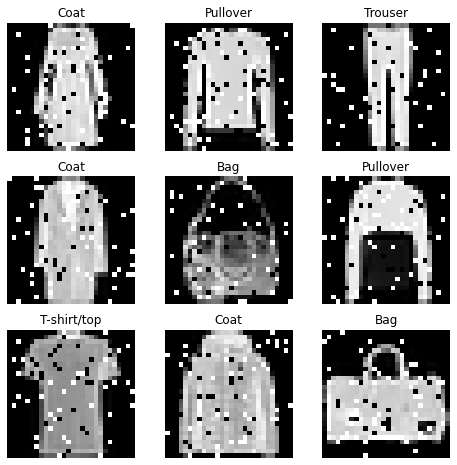

In [6]:
# Get image through dataset class
print(f'Training data size :{len(training_data)}')
print(f'Testing data size :{len(test_data)}')
print(f'Training data shape :{training_data[0][0].shape}')
print(f'Testing data shape :{test_data[0][0].shape}')
labels = {'0' : 'T-shirt/top',
'1' :'Trouser',
'2'	:'Pullover',
'3'	:'Dress',
'4'	:'Coat',
'5'	:'Sandal',
'6'	:'Shirt',
'7'	:'Sneaker',
'8'	:'Bag',
'9'	:'Ankle boot'}
def view_data(X_train = training_data):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(X_train), size=(1,)).item()
        img, label_id = X_train[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels[str(label_id)])
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray") # squeeze is needed otherwise we will get error / 
                                            # TypeError: Image.__init__() takes 1 positional argument but 2 were given
    plt.show()
    
view_data()


In [22]:
# We will flatten tensors in NN

# Transform Dataset into dataloader instance for batching and shuffling capabilities
train_loader = torch.utils.data.DataLoader(training_data,
                                          batch_size=16,
                                          shuffle=True,
                                          num_workers=0, # cpu_count
                                          )
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=16,
                                          shuffle=True,
                                          num_workers=0, # cpu_count
                                          )

# Define Model structure

In [23]:
import torch.nn as nn

class DAE(nn.Module):
    def __init__(self):
        super(DAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True)
        )
        
        self.decoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Training loop

Todo:
- training loop is wrong
- remove adding noise


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Define your denoising autoencoder model
model = DAE().to(device)

# Define loss function
criterion = nn.MSELoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    
    for images, _ in train_loader:
        # Flatten the input images
        images = images.view(images.size(0), -1).to(device)
        
        # Add noise to the input images
        noisy_images = images + torch.randn_like(images) * 0.1
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(noisy_images)
        
        # Compute the loss
        loss = criterion(outputs, images)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Training finished.")


Epoch [1/10], Loss: 0.0597
Epoch [2/10], Loss: 0.0525
Epoch [3/10], Loss: 0.0507


KeyboardInterrupt: 